In [1]:
import os, sys

import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.signal import freqz, sosfreqz, sosfilt, coherence
from scipy.signal import butter, lfilter
import librosa

In [3]:
from dsp import resample
from dsp import load_fir, load_sos, sos_to_fir
from dsp import firfilt, xfilt
from dsp import spectral_args
from dsp import attenuation

In [4]:
from anc.simulation import anc_simulation

In [5]:
spectral_args

{'fs': 192000,
 'window': 'hann',
 'nperseg': 16384,
 'noverlap': 8192,
 'nfft': 16384,
 'detrend': False,
 'return_onesided': True,
 'scaling': 'spectrum'}

In [6]:
fs = 192000
nfft = 2048

# Load necessary data

### load FF & FB parameters

In [7]:
path_ff = "results/ff.csv"
path_fb = "results/fb.csv"

FF_sos = load_sos(path_ff)
FB_sos = load_sos(path_fb)

### load PP & SP responses

In [8]:
dataset_path = "/home/alexey/Documents/python/github/active-noise-control/datasets/PANDAR"

fs_data = 48000

path_pp = f"{dataset_path}/PP/PP_PersonID7_L_normal.txt"
path_sp = f"{dataset_path}/SP/SP_PersonID7_L_normal.txt"

PP_48k = load_fir(path_pp)
SP_48k = load_fir(path_sp)

PP = resample(PP_48k, fs=fs_data, fs_new=fs)
SP = resample(SP_48k, fs=fs_data, fs_new=fs)

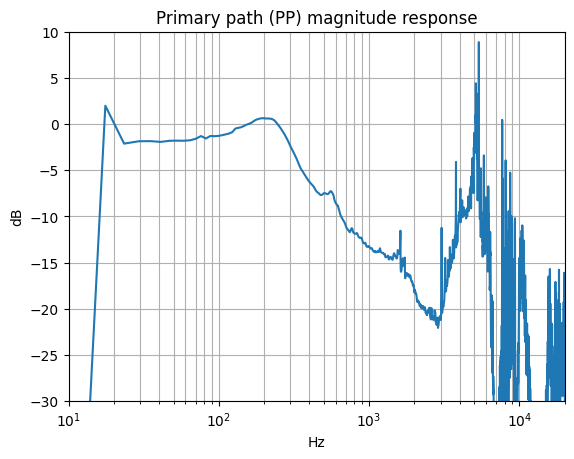

In [9]:
w, h = freqz(PP, a=1, worN=16384, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)));

plt.grid(which="both");
plt.xlim(10, 20000);
plt.ylim(-30, 10);

plt.title("Primary path (PP) magnitude response")
plt.xlabel("Hz");
plt.ylabel("dB");

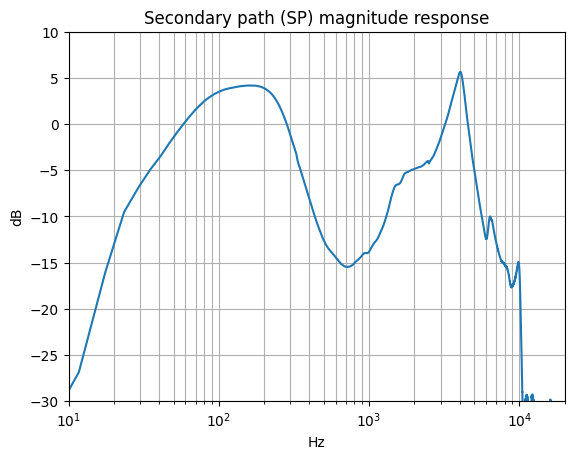

In [10]:
w, h = freqz(SP, a=1, worN=16384, whole=False, fs=fs)
plt.semilogx(w, 20 * np.log10(np.abs(h)));

plt.grid(which="both");
plt.xlim(10, 20000);
plt.ylim(-30, 10);

plt.title("Secondary path (SP) magnitude response")
plt.xlabel("Hz");
plt.ylabel("dB");

# Run ANC simulation and estimate the performance

In [11]:
duration = 2 # sec
length = int(duration * fs)

### generate artificial data

In [12]:
np.random.seed(0)

ref = np.random.randn(length)
noise = np.random.randn(*ref.shape) * 0.03
erp = firfilt(PP, ref) + noise

### FF

In [13]:
erp_ff = firfilt(SP, xfilt(FF_sos, ref)[0])

f, att_ff = attenuation(erp_ff - erp, erp, **spectral_args)

### FB

In [14]:
erp_fb = anc_simulation(None, erp, None, FB_sos, SP, verbose=True)

f, att_fb = attenuation(erp_fb - erp, erp, **spectral_args)

100%|█████████████████████████████████| 384000/384000 [01:23<00:00, 4577.42it/s]


### FF + FB

In [15]:
# erp_fffb = anc_simulation(ref, erp, FF_sos, FB_sos, SP, verbose=True)
# f, att_fffb = attenuation(erp_fffb - erp, erp, **spectral_args)

att_fffb = att_ff + att_fb # approximation at the ERP

/tmp/ipykernel_27147/2439155425.py:10: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, 20000);


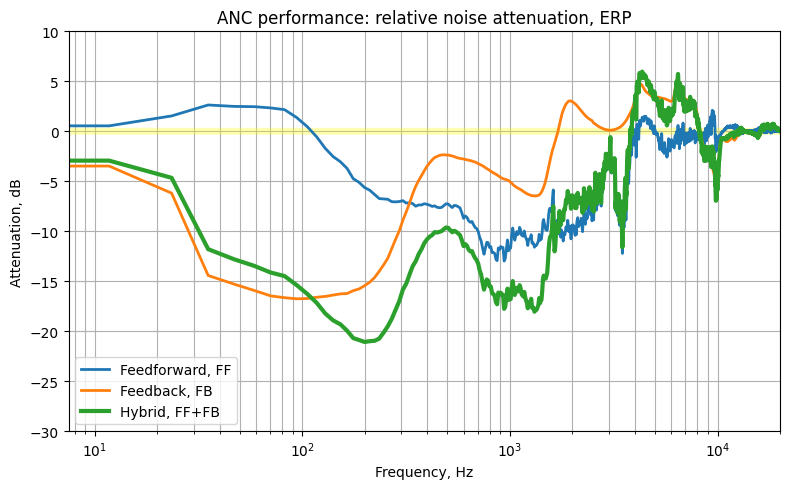

In [16]:
plt.figure(figsize=(8, 5));

plt.semilogx(f, np.zeros_like(f), color="yellow", linewidth=5, alpha=0.3);

plt.semilogx(f, att_ff, label="Feedforward, FF", linewidth=2);
plt.semilogx(f, att_fb, label="Feedback, FB", linewidth=2);
plt.semilogx(f, att_fffb, label="Hybrid, FF+FB", linewidth=3);

plt.grid(which="both");
plt.xlim(0, 20000);
plt.ylim(-30, 10);
plt.legend();
plt.title("ANC performance: relative noise attenuation, ERP");
plt.xlabel("Frequency, Hz");
plt.ylabel("Attenuation, dB");

plt.tight_layout();
plt.savefig(f"attenuation.png", dpi=300); # move to /images